# General Sequence-to-Sequence Mappings

## Building Encoder-Decoder LSTM Models

Many times, we want to map an *arbitrary length* sequence to another *arbitrary length* sequence for a machine learning task. The most common example would probably be machine translation where the number of characters/words used to encode a sentence in one language rarely matches with the number of characters/works used to encode a sentence with the same meaning in another language. Thus, the many-to-many mapping used by the simple recurrent network used previously in lecture would not be approprite.

In order to accomplish this task, the most common architecture used at this time is the *encoder-decoder* framework. First, we build an *encoder* network which takes an arbitrary length input sequence, and **encodes a distributed representation** of that input sequence using the hidden layer of a recurrent network. This is similar to a standard many-to-many recurrent network, except there is *no output layer for the encoder*. Instead, the input sequence information is simply folded into the *recurrent* hidden layer activation pattern at each time step. Once the encoder finishes generating this *gestalt* representation (created using the the entire input sequence), it is fed into a *decoder* network which translates the *gestalt* representation into the corresponding output sequence using another recurrent hidden layer and time-distributed output layer. Special *start* and *stop* patterns are used to encode for the starting and ending points of target sequences during training. Therefore, the *decoder* network learns to indicate when it is ready to start and finish a particular output sequence. Using its two subnetworks, the encoder-decoder framework forms a general sequence-to-sequence learning framework.

In order to illustrate how to build and train an encoder-decoder network, we will utilize the parity task from the simple recurrent network example. Even though the sequence lengths are the same for both the input and output for this task, we can still utilize it to illustrate the core concepts involved. Also, we will be using long short-term memory for the recurrent layers of these networks to show their effectiveness at learning these kinds of tasks.

In [1]:
# Import what we need for the job...
import tensorflow.keras as keras

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Visualization
from IPython.display import display

Let's create the parity problem again, but we need to encode the input and target sequences a bit more generically this time to show how the process might be generalized to other types of sequence processing domains.

One key idea is that we need to map our possible sequence elements into a **one-hot encoded dictionary** which will be useful for arbitray sequence specification for both the encoder and decoder parts of the network. We will use the following mapping:

Input Sequences:

| Symbol | One-hot Encoding |
| --- | --- |
| `0` | `10` |
| `1` | `01` |

Ouput Sequences:

| Symbol | One-hot Encoding |
| --- | --- |
| `0` | `1000` |
| `1` | `0100` |
| start | `0010` |
| stop  | `0001` |

This encoding will necessarily make the problem easier to solve (0 is now mapped to a meaningful orthogonal dimension to the other symbols), but more importantly, it shows how each symbol in the input/output sequences needs an orthogonal dimension in the encoded form. Other distributed codes may also work, but high dot product similarity between vectors in a chosen encoding scheme may affect the network's learning capabilities in unpredictable ways (more than likely negative). Also, it should be clear here that we don't even need to have the same *symbols* in the encoder and decoder networks. They can be arbitrary mappings in both time and space, which makes this a powerful, flexible approach.

OK, so let's generate a large set of training and testing sequences for the network to experience on this task...

In [2]:
# Length of sequences to model
length = 10

# Note we are making these the same, but they don't -have- to be!
input_length = length
output_length = length

As a good rule of thumb, we just want to **create a network and train it to learn just a single example first**. After that, we can extend it to a larger data set.

In [3]:
# Generate a random string of 0s and 1s
x_train = np.round(np.random.uniform(0,1,[length])).reshape([1,length,1])
x_train

array([[[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]]])

In [4]:
# Calculate parity (note this is the same algorithmic approach
# that we are trying to encourage our net to learn!)
def parity(x):
    temp = np.zeros(x.shape)
    mem = False
    # Iterate over the sequence
    for i in range(x.shape[0]):
        if x[i,0] > 0.5:
            current = True
        else:
            current= False
        mem = np.logical_xor(mem,current)
        if mem:
            temp[i,0] = 1.0
        else:
            temp[i,0] = 0.0
    return (temp.reshape(1,temp.shape[0],temp.shape[1])) # Tensor!

In [5]:
y_train = parity(x_train[0,:,:])
y_train

array([[[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]]])

Let's turn these into a set of encoded input-output vectors using the transformation above.

In [6]:
X = np.expand_dims(keras.utils.to_categorical(x_train[0,:,0]),axis=0)
X

array([[[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]]], dtype=float32)

In [7]:
Y = np.expand_dims(np.vstack([np.array([0,0,1,0]),
                   np.hstack([keras.utils.to_categorical(y_train[0,:,0]),
                              np.zeros([output_length,2])]),
                   np.array([0,0,0,1])]),axis=0)
Y

array([[[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

Also, note the shapes of the sequences...

In [8]:
X.shape

(1, 10, 2)

In [9]:
Y.shape

(1, 12, 4)

We will need to divide the target data into two groups which correspond to the input-target pairs for the *decoder* network. In essence, the decoder network is really just a many-to-many recurrent network, and will be trying to predict the next part of the target sequence (`postY`) given *both* the encoder output representation *and* the previous target sequence entry (`preY`). This previous target sequence entry is not strictly necessary, but using it represents a training strategy called *teacher forcing* which makes it easier to learn some sequences.

In [10]:
# 12 time steps total (10 + start + stop)
# Divide into two groups of 11
# First from 0 ... 10
preY = Y[:,0:output_length+1,:]
# Second from 1 ... 11
postY = Y[:,1:output_length+2,:]

In [11]:
preY.shape

(1, 11, 4)

In [12]:
postY.shape

(1, 11, 4)

OK, let's make an encoder-decoder framework for learning this sequence. We need to use the Keras *functional* API for building this network as well. To create networks of this kind, we first create `layer` objects and then call their `()` functions to make them take inputs from the provided layers' outputs. This allows for networks to receieve input from more than one layer at a time, or pass their outputs to more than one layer at a time. Once all of the layers have been connected in the desired ways, then we create a `Model` object used to specify the input and output layers for the overall model. This allows for more general network topologies to be constructed than can be achieved with the *sequential* API.

Generally, the process looks like the following pseudocode:
1. mylayer = Layer(...)
2. mylayer_output(s) = mylayer(input_layer(s))
3. Provide mylayer_output(s) as the input_layer(s) to another layer (going back to step 1 as many times as needed)
4. model = Model(input_layer(s), output_layers())
5. Compile and run the new model...

In this way, outputs from a layer may be passed as inputs to other layers for chaining layers together. The final model is specified by giving it only the input and output layers since all intervening layers were connected together at the previous stage (they are implicitly incorporated into the model).

In [13]:
# Size of the gestalt, context representations...
hidden_size = 20

## Encoder Construction

# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in) 
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]

## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size,
                                   return_sequences=True,
                                   return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
    decoder_input, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# Compile it...
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20), (None,  1840        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 20), ( 2000        input_2[0][0]                    
                                                                 lstm[0][1]                   

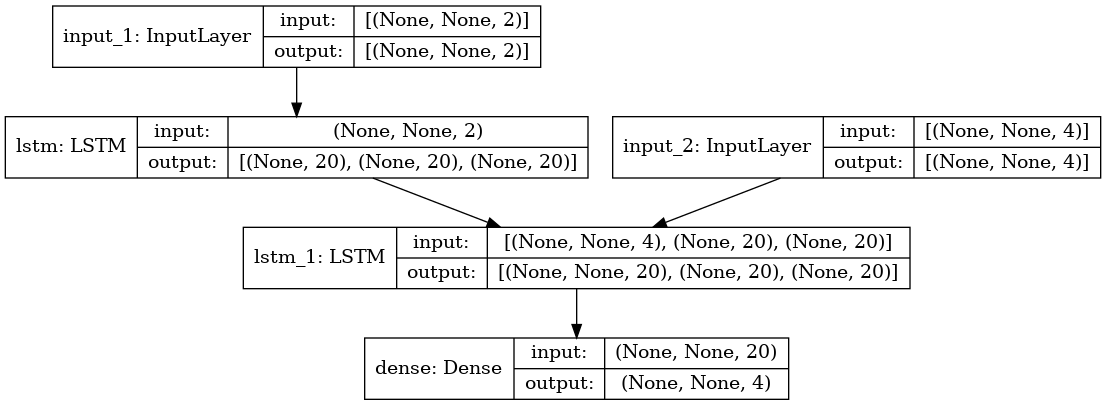

In [14]:
# Visualization - wish we could see the recurrent weights!
keras.utils.plot_model(model,to_file='encdec.png',
                       show_shapes=True,expand_nested=True)

So, these visualizations are a little helpful now, maybe? Layer input_1 will accept the input sequence information, which will be folded up into a gestalt representation by the lstm_1 layer. As a second phase, we will initially provide input_2 the **start** token which allows lstm_2 to use both this token and the gestalt representation from lstm_1 as input for beginning to decode the sequence. This final output layer (dense_1) will output the desired token, which will then also (eventually) be copied back into input_2. However, during training we need to provide this information directly as a data matrix, so it is clear how the *teacher forcing* that layer provides a little more support to the learning. This is because, during training, we will ouput provide input_2 with what dense_1 **should** be producing instead of its actual output. Later, we will see how to manually feed the output from the final dense layer back into this layer when performing prediction once it has learned the sequence properly. In this way, we will turn off the teacher forcing component when testing the performance of the network.

In [15]:
batch_size = 1   # only one pattern...
epochs = 200
history = model.fit([X,preY], postY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0)
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

1/1 [==============================] - 0s 365ms/step - loss: 0.3101 - categorical_accuracy: 0.9091
Accuracy: 90.90909361839294 %


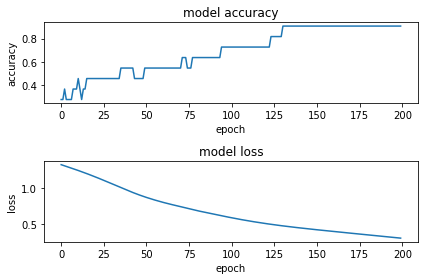

In [16]:
plt.figure(1)  
# summarize history for accuracy 
plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.tight_layout()
plt.show()  

The network appears to have learned the sequence, but there is one thing wrong with the final evaluation: the *teacher forcing* inputs are still being provided on each time step. Instead, we should be feeding the *output* from the decoder back into this input layer, so that it can use *it's own predictions* to forecast the next step. If we had left off the teacher forcing inputs entirely, this would not have been necessary, but let's make a more proper test of the network now.

In order to accomplish this part of the job, we will construct *another* model, but just **reuse the layers** already defined and trained before. This will allow us to connect the layers together to create a model which accomplishes the feedback loop for us ...

In [17]:
# Part 1 - make the encoder

# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)

# Part 2 - make the decoder

# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
    decoder_input, initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

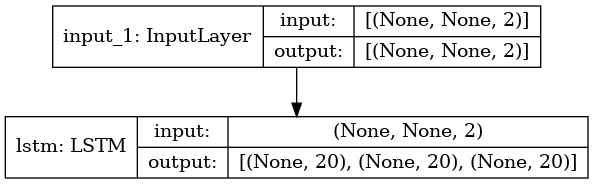

In [18]:
# Separated Encoder Model
keras.utils.plot_model(encoder_model,to_file='enc.png',
                       show_shapes=True,expand_nested=True)

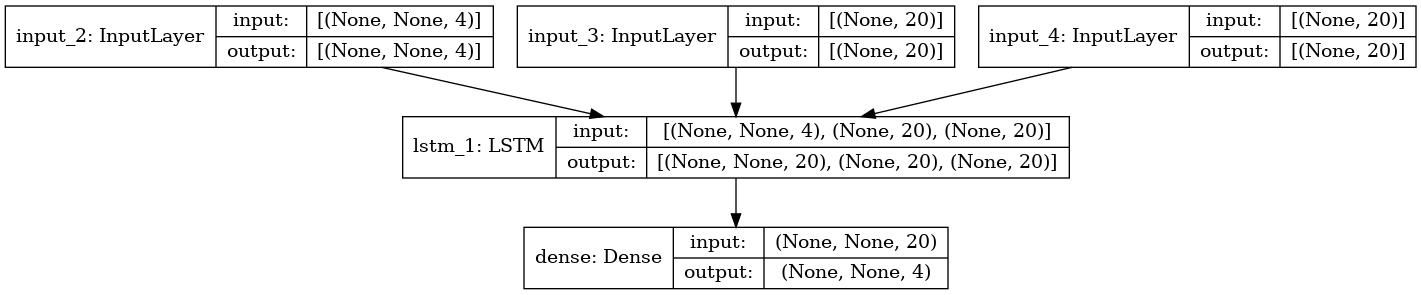

In [19]:
# Separated Decoder Model
keras.utils.plot_model(decoder_model,to_file='dec.png',
                       show_shapes=True,expand_nested=True)

OK, at this point, it's important that we slow down and think about what we have just constructed here. This network (now a **pair** of models) is not going to be *trained* in any way, and it (mostly) just reuses layers that have already created (*and* trained) in the earlier part of this example. Therefore, we are just going to rearrange some of the layers into *two* new models to make it easier to probe the network. These parts will naturally be the encoder and the decoder. However, these new models will just be used for *prediction* instead of training.

The basic idea is that we need to *first* encode the input sequence into its *gestalt* context representation. This is the job of the encoder, and this part is rather straight-forward because the encoder network architecture remains practically unchanged: we just didn't give the encoder it's own, independent model before. Therefore, we could *not* just extract a hidden layer representation without also feeding it into the input layer of the decoder. The new `encoder_model` now just takes our input sequence and provides us with the output "states" or *activations* of the LSTM units. We can use the `predict()` method now to easily obtain those representations.

The second part of the decoding process involves making a new set of inputs for the decoder which will accept the state information from the encoder outputs (in addition to the sequence starting token). This uses two layers which are just standard input layers set to the corresponding size of the LSTM outputs from the encoder. This just allows us to transfer that information over to the decoder *manually* by copying the output values from the encoder into these input layers. The hidden layer of the decoder then takes the encoder's hidden layer information and an input token vector (decoder_input, just like before).

Instead of using teacher forcing to make the sequence input equal to a prescribed target token (like we did during training), here we will only provide the *start* token along with the encoder's gestalt context. After that, we will let the decoder produce an output value. This output value will then be rounded to the nearest value (it's a graded prediction, so we clean it up a little in this obvious way), and then we will feed it *back* into the decoder for the next time step (along with the updated decoder hidden layer activations as well which take the place of the encoder network's initial context information). So long as we provide the encoder's activations and the *start* token on the first step. The decoder network is then asked to step through this series of steps repeatedly until it reaches the *stop* token (or a maximum number of steps is reached). In our case, all sequences are of the same length, so we will expect it will reach the stop token by the 11th output.

Let's walk through these steps by calculating the context from the encoder using our input sequence, `X`, then providing the *start* token (`0010`) to the encoder output as the first inputs to the decoder. Then we will recycle the decoder's output and hidden representations back into the network, just predicting one time step at a time until the sequence terminates.

In [20]:
# Get the gestalt context for the input sequence(s)
context = encoder_model.predict(X)

# Prep a starting token [[[0,0,1,0]]]..
token = np.zeros([1,1,Y.shape[2]])
token[0,0,2] = 1
token

array([[[0., 0., 1., 0.]]])

In [21]:
# Complete 11 cycles with the decoder
result = np.zeros(postY.shape)
for x in range(output_length+1):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
result

array([[[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

In [22]:
# Let's compare with the pattern
postY

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]])

And we have a match! Looks like the encoder-decoder had no trouble learning the sequence. Note that we could wait for the *stop* token instead of counting the number of steps above and we would have come to the same result since that token was encountered on the last iteration. That is, the network learns to generate the correctly sized sequence when required.

OK, so now, let's take the same approach as we used above to learn a **larger number of sequences** ...

In [23]:
# New length
length = 10
input_length = length
output_length = length

# Set number of patterns here
n_seq = 100

# Generate the Xs
x_train = np.concatenate([np.round(
    np.random.uniform(0,1,[length])).reshape([1,length,1])
                          for x in range(n_seq)])
y_train = np.concatenate([parity(x_train[x,:,:]) for x in range(n_seq)])

# Reformat - dictionary approach
X = np.concatenate([np.expand_dims(
    keras.utils.to_categorical(x_train[x,:,:]),axis=0)
                    for x in range(n_seq)])
Y = np.concatenate([np.expand_dims(
    np.vstack([np.array([0,0,1,0]),
               np.hstack([keras.utils.to_categorical(y_train[x,:,:]),
                          np.zeros([output_length,2])]),
               np.array([0,0,0,1])]),axis=0) for x in range(n_seq)])
preY = Y[:,0:length+1,:]
postY = Y[:,1:length+2,:]

In [24]:
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(100, 10, 2)
(100, 12, 4)
(100, 11, 4)
(100, 11, 4)


In [25]:
# Same as before...

# Size of the gestalt, context representations...
hidden_size = 20

## Encoder Construction

# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in) 
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]

## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size,
                                   return_sequences=True,
                                   return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
    decoder_input, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)

# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)

# Compile it...
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 20), (None,  1840        input_5[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 20), ( 2000        input_6[0][0]                    
                                                                 lstm_2[0][1]               

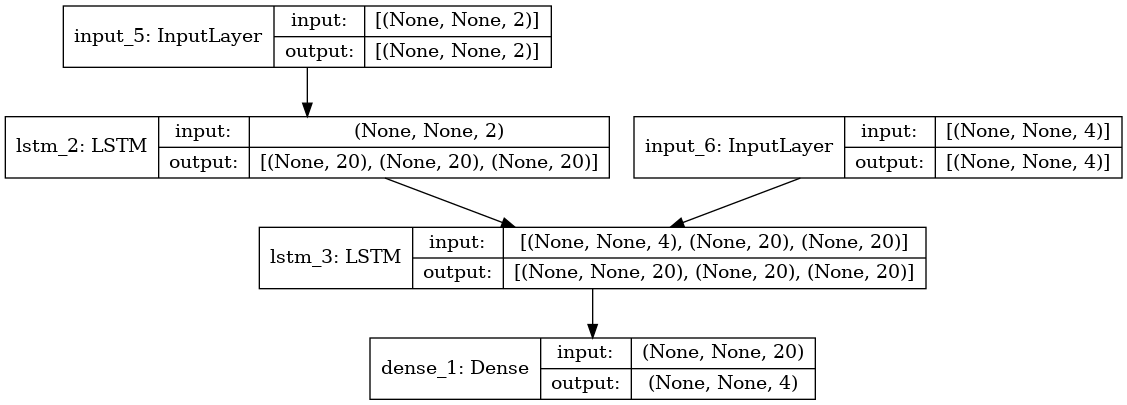

In [26]:
# Visualization - same as before...
keras.utils.plot_model(model,to_file='encdec2.png',
                       show_shapes=True,expand_nested=True)

In [27]:
batch_size = 20   # many patterns...
epochs = 1500
history = model.fit([X,preY], postY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,              # Turning off output due to many epochs...
          validation_split = 0.2)
# Remember, teacher forced, but a little informative...
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

4/4 [==============================] - 0s 3ms/step - loss: 0.1935 - categorical_accuracy: 0.9227
Accuracy: 92.27272868156433 %


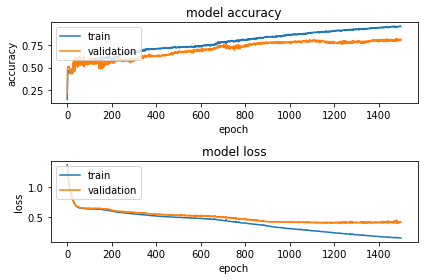

In [28]:
plt.figure(1)
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()  

In [29]:
## Testing - Again, separate the encoder-decoder for teacher forcing...

# Part 1 - make the encoder

# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)

# Part 2 - make the decoder

# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(
    decoder_input, initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

In [30]:
# Testing time...
error = 0
for p in range(n_seq):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[p:p+1,:,:])

    # Prep a starting token [[[0,0,1,0]]]..
    token = np.zeros([1,1,Y.shape[2]])
    token[0,0,2] = 1
    token

    # Complete 11 cycles with the decoder
    result = np.zeros(postY.shape)
    for x in range(output_length+1):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    error += np.sum(np.abs(result-postY[p:p+1,:,:]))/2.0

In [31]:
print("Overall accuracy: %f%%"%(100.0 - (error / (n_seq*output_length))))

Overall accuracy: 85.950000%


For the final accuracy calculation, we loop through all of the training patterns and count up all of the missed tokens. This can be expressed as the absolute difference between the predicted output sequence, and the one from the `postY` pattern set (divided by two). The accuracy therefore isn't really how many sequences were correctly classified, but how many tokens the network missed. At this point, then encoder-decoder has made it to about 90% accuracy on all tokens, so with a little more training (or tweaks to the architecture), we might get even further. For example, we could change the activation function from `tanh` (the default for LSTM) to `relu`, try adding more units to the hidden layers, or just stack some additional LSTM layers onto the encoder or decoder networks. 

## Learning to Write Like Jane Austen

Jane Austen's *Pride and Prejudice* was the number one requested e-book on Project Gutenberg at the time of writing up this tutorial. As a result, let's see if we can train a recurrent network to write like a genius! We will be parsing the raw text line-by-line and then asking our network to learn, given one line, what the next line should be = literal genius?, literally genius? no, no: literary genius. :-)

The basic text is split into lines already, and extra new lines are placed between paragraphs. We will end up parsing the entire text, but only learning on a small part of it for this example. I will ask you to emulate the process in the assignment below and learn a little more of the text...

First, let's read in the text and do some preprocessing on it... (Note that the !head command just lets us preview the first few lines of the file, and isn't a piece of python code! It's cell right after that actually loads the data.)

**Be careful not cut off this link below!!**

`!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt`

In [32]:
!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt

--2021-04-07 13:42:14--  https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt
Resolving www.cs.mtsu.edu (www.cs.mtsu.edu)... 161.45.162.100
Connecting to www.cs.mtsu.edu (www.cs.mtsu.edu)|161.45.162.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683838 (668K) [text/plain]
Saving to: ‘PandP_Jane_Austen.txt.1’

PandP_Jane_Austen.t 100%[===================>] 667.81K  --.-KB/s    in 0.06s   

2021-04-07 13:42:15 (11.0 MB/s) - ‘PandP_Jane_Austen.txt.1’ saved [683838/683838]



In [33]:
!head PandP_Jane_Austen.txt

It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered the rightful property
of some one or other of their daughters.

"My dear Mr. Bennet," said his lady to him one day, "have you heard that
Netherfield Park is let at last?"


In [34]:
# Preprocessing - grab lines from the file
with open('PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
min_length = max([len(i) for i in text])

# Visual Confirmation that we have loaded the text in...
text[0:8]

['It is a truth universally acknowledged, that a single man in possession',
 'of a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his',
 'first entering a neighbourhood, this truth is so well fixed in the minds',
 'of the surrounding families, that he is considered the rightful property',
 'of some one or other of their daughters.',
 '"My dear Mr. Bennet," said his lady to him one day, "have you heard that',
 'Netherfield Park is let at last?"']

The reading process reads in the text, but then drops the blank lines between paragraphs. After that, we determine the length of the longest string in the text. I call it `min_length` because it's the minimum size of sequence that our network will read (and for other reasons below), so don't be confused by the name. We will only use it on special occasions anyway...

We will also read in the list of unique characters used in this text. I've already pre-processed this information from the file above using a piece of C++ code that I had laying around, but it wouldn't be difficult to do the same using a `set` in Python. I'll leave that as an exercise for your own amusement at some other time.

Here's the list of unique characters, one-per-line...

**Be careful not cut off this link below!!**

`!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/unique_chars.txt`

In [35]:
!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/unique_chars.txt

--2021-04-07 13:42:39--  https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/unique_chars.txt
Resolving www.cs.mtsu.edu (www.cs.mtsu.edu)... 161.45.162.100
Connecting to www.cs.mtsu.edu (www.cs.mtsu.edu)|161.45.162.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136 [text/plain]
Saving to: ‘unique_chars.txt.1’

unique_chars.txt.1  100%[===================>]     136  --.-KB/s    in 0s      

2021-04-07 13:42:39 (15.8 MB/s) - ‘unique_chars.txt.1’ saved [136/136]



In [36]:
!head unique_chars.txt

!
"
'
(
)
*
,
-
.
1


In [52]:
# Unique characters - precalculated
with open('unique_chars.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
lines = [line for line in lines if line != '']

# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
# Symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

Note that I have added a couple of *extra* tokens to the list ('START','STOP', and a space - wasn't counted as a character by my C++ implementation) and have created data structures for mapping from a character to an integer code (`stoi`) and from an integer code to a character (`itos`). We can use these structures later to map back and forth between human-readable and network-readable encodings.

Let's see what size the text corpus is now...

In [53]:
# Total number of sentences
len(text)

10658

In [54]:
# Longest sentence - plus start/stop
max(len(i) for i in text)+2

76

In [55]:
# Number of tokens (each will be one-hot encoded)
len(itos)

71

OK, so we have 10,658 lines of text and the *longest* line we have in the text is 76 tokens (we add 2 for the start and stop tokens that we will add to these sentences). You can also see that there are 71 unique tokens identified for this text, which will be the input layer size for our network.

Let's prepare functions which will map a sentence to a one-hot vector (encoding) and also reverse this process when needed (decoding).

In [56]:
def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))

def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [57]:
# An encoding-decoding cycle on the first line...
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It is a truth universally acknowledged, that a single man in possession'

In [58]:
# What was the first line in its original form?
text[0]

'It is a truth universally acknowledged, that a single man in possession'

I will leave it to you to see what the encoded form likes like if you are curious, but we can clearly both encode and decode these vectors properly.

Now, we process all of the data in the text corpus with this information...

You will notice one strange thing here. I will first create a matrix specifying an equal probability of observing any token (1/71). This is because softmax can't produce an output vector of all zeros and some of the encoded strings are not 76 elements long. So, the remaining time steps must be completed with something that the softmax function can potentially match. Softmax will *never* be able to match a *flat* (all-zero) distribution, and I don't want to skew our final results by asking the network to interpret and adjust to values which are literally *impossible* for the network to utilize. This is because we will use the final output from the network as input again to predict the next sentence later on. Therefore, the input and output encodings should be consistent to match this expectation...

In [59]:
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2,
                 len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(text),max([len(i) for i in text])+2,
                 len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp

Now we split this into input (`X`) and pre- and post-step decoder inputs (`preY` and `postY`)...

In [60]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

Let's decide on how much P&P we really want to learn about. For this example I will just show you how work with 5 sentences, but more could be used...

In [61]:
nlines = 5

X = X[0:nlines,:,:]
Y = Y[0:nlines,:,:]
preY = preY[0:nlines,:,:]
postY = postY[0:nlines,:,:]

print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(5, 76, 71)
(5, 76, 71)
(5, 75, 71)
(5, 75, 71)


We will not be using the entire text here. In essence, we are asking it to memorize what comes next in sequence from start to finish, and the first 5 sentence pairs will be used as a benchmark to see if anything useful is learned from this training regime. We will see if it can encode and recall these sentences after training, both *with* and *without* teacher forcing.

It's now time to define the network needed to solve this problem... this will be part of the assignment as outlined below, so use the example above on learning the parity problem to construct a network appropriate for the "Jane Austen" problem. Remember, a large hidden layer may be needed to encode *many* sentence structures, but I just used 3\*76 for the examples below. You may need a larger network when encoding longer parts of the text. I've kept the `summary()` output for my model below to provide some additional hints. 

In [63]:
# Your model here!

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500), (None, 1144000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 500),  1144000     input_2[0][0]                    
                                                                 lstm[0][1]                   

Training consists of running through the sequence set many times. We will train a *reasonable* amount here for this problem. If you wanted to increase the number of epochs or use a batch size to encourage faster convergence when you train, that may be helpful...

In [67]:
batch_size = nlines   # number of patterns...
epochs = 300
history = model.fit([X,preY], postY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0)
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

1/1 [==============================] - 0s 416ms/step - loss: 0.8395 - categorical_accuracy: 0.9067
Accuracy: 90.66666960716248 %


Remember that accuracy is an ill-posed metric for this problem because some of the time steps will go beyond the number of characters in the sentence being produced. Softmax will try to find a way to match an identical and independent distribution of characters on these padded regions. However, the accuracy metric will first find the highest value and make a binary decision (correct/incorrect), which isn't really the best way to treat those padded regions. Therefore, 100% accuracy is not really a possibility for this problem as it is defined. If we didn't want to feed the output sentence back in later, we could change the padded regions to all stop tokens and see a better representation of learning. However, we most deinitely *do* want to see how the network is at writing the text of P&P. With enough sequences, it might just start to make sense...

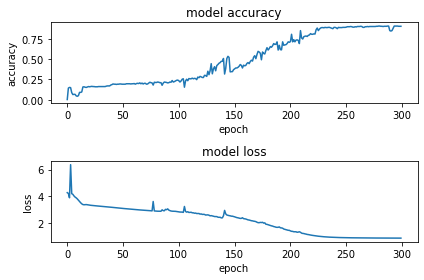

In [68]:
plt.figure(1)  
# summarize history for accuracy 
plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.tight_layout()
plt.show()

The crafting of the `encoder_model` and `decoder_model` will need to be done as part of the assignment below, but should *very* closely follow the pattern set by the parity example above. We will again use this restructured model to manually provide sentence data to our encoder, then provide the encoder hidden layer representation as input to the decoder, and finally see how well the decoder does at generating the intended *next* sentence from the text. Let's see how it goes!

In [69]:
# Your encoder_model and decoder_model here!

Let's examine the process of passing just the first sentence into the net...

In [71]:
# Get the gestalt context for the input sequence(s)
i = 0
context = encoder_model.predict(X[i:i+1,:,:])

# Prep a starting token...
token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [72]:
# What should we see?
print('Input:', text[i])
print('Output:', text[i+1])

Input: It is a truth universally acknowledged, that a single man in possession
Output: of a good fortune, must be in want of a wife.


In [73]:
# Complete max cycles with the decoder
result = np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c = decoder_model.predict([token]+context)
    token = np.round(out)
    context = [h,c]
    result[:,x,:] = token
decode_seq(result[0,:,:],itos)

'of good fortune, must be in want of a wife.'

It's starting to be able to generate the required sentence! We could make changes to the network architecture, hyperparameters, or other changes before training in order to better match the expected output. You will note that the output is not being *teacher-forced* on the level of individual characters. That is, we are feeding in the predicted output token back in to the `predict()` function on the next iteration. Therefore, there is no teacher forcing being used on this example. However, it's just a single sentence. Let's see how it does on all 5 sentences....

In [74]:
# Iterate - teacher forcing through each line
for i in range(0,nlines):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])

    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))

    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: of a good fortune, must be in want of a wife.
Net: of good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: of e one or other of their daughters.
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: of good fortune, must be in want of a wife.
Txt: of the surrounding families, that he is considered the rightful property
Net: of good fortune, must be in want of a wife.
Txt: of some one or other of their daughters.
Net: of some one or other of their daughters.


This is just the same code above run over the set of sentences that we used to train the network. Also, we are resetting the encoder with the *correct* input sequence on each step. So, although there is no teacher forcing being used at the level of individual characters, there is still teacher forcing being used at the level of sentences. This is pretty good performance, so you can expect it to do a little worse when this teacher forcing is turned off as well...

In [75]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])

for i in range(0,nlines):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))

    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: of a good fortune, must be in want of a wife.
Net: of good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: of od fortune, must be in want of a wife.
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: of od fortune, must be in want of a wife.
Txt: of the surrounding families, that he is considered the rightful property
Net: of od fortune, must be in want of a wife.
Txt: of some one or other of their daughters.
Net: of od fortune, must be in want of a wife.


Now we have turned off *all* teacher forcing, and you can see that the network is struggling to utilize its own noisy predictions to generate the next sentence. Nevertheless, it appears to recover later in the text and gets back on track. This is kind of interesting because when people are presented with memorization tasks, it has been shown that people are more likely to remember the details of passages at the beginning and end. That is, sections in the middle are more likely to be forgotten. It looks like this network is suffering from a similar type of problem as human learners...